#Baseline rhythm generation model
- modified based on Hungyi-Lee's HW8 structure: https://colab.research.google.com/drive/11iwJbQv9iScRo6kGP7YfyHaaorlHhzMT

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

import numpy as np
import sys
import os
import random
import json
import re
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class LabelTransform(object):
    def __init__(self, size, pad):
        self.size = size
        self.pad = pad

    def __call__(self, label):
        label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
        return label

In [3]:
class RhythmDataset(data.Dataset):
    def __init__(self, root, max_output_len, set_name):
        self.root = root
        self.max_output_len = max_output_len
        self.word2int, self.int2word = self.get_dictionary()

        # 載入資料
        self.data = []
        with open(os.path.join(self.root, f'{set_name}'), "rb") as f:
            self.data=pickle.load(f)
            print (f'{set_name} dataset size: {len(self.data)}')

        self.vocab_size = len(self.word2int)

        self.transform = LabelTransform(max_output_len, self.word2int['<PAD>'])

    def get_dictionary(self):
        # 載入字典
        with open(os.path.join(self.root+'/rhythm_dict', f'vocab_word2int.json'), "r") as f:
            word2int = json.load(f)
        with open(os.path.join(self.root+'/rhythm_dict', f'vocab_int2word.json'), "r") as f:
            int2word = json.load(f)
        return word2int, int2word

    def __len__(self):
        return len(self.data)

    def __getitem__(self, Index, pad=False):
        global device
        sentence = self.data[Index]
        sentence_idx = []
        for word in sentence:
            if (word in self.word2int.keys()):
                sentence_idx.append(self.word2int[word])
            else:#如果遇到不会的单词就赋给不知道
                sentence_idx.append(self.word2int["<UNK>"])
        if pad:
            sentence_idx = np.asarray(sentence_idx)
            sentence_idx = self.transform(sentence_idx)

        sentence_idx = torch.LongTensor(sentence_idx).to(device)
        target = sentence_idx.clone()
        return sentence_idx, target

In [4]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input: [batch_size, sequence_len]
        embedding = self.embedding(input)
        outputs, hidden = self.rnn(self.dropout(embedding))
        # outputs: [batch_size, sequence_len, hid_dim * directions]
        # hidden:  [num_layers * directions, batch_size  , hid_dim]
        return outputs, hidden

    def get_embedding(self, input):
        # input: [batch_size, sequence_len]
        embedding = self.embedding(input)
        return embedding

In [5]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.hid_2xdim = hid_dim * 2
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, config.emb_dim)
        self.input_dim = emb_dim + hid_dim * 2
        self.attention = Attention(self.hid_2xdim, n_layers)
        self.rnn = nn.GRU(self.input_dim, self.hid_2xdim, self.n_layers, dropout = dropout, batch_first=True)
        self.embedding2vocab1 = nn.Linear(self.hid_2xdim, self.hid_2xdim * 2)
        self.embedding2vocab2 = nn.Linear(self.hid_2xdim * 2, self.hid_2xdim * 4)
        self.embedding2vocab3 = nn.Linear(self.hid_2xdim * 4, self.vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input: [batch_size, 1]
        # hidden: [batch_size, n_layers * directions, hid_dim]
        # Decoder's directions=1
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        # embedded: [batch_size, 1, emb_dim]
        attn = self.attention(encoder_outputs, hidden) #[batch size, 1, hid_dim*2]
        embedded = torch.cat((attn,embedded),dim=2) #[batch size, 1, input_dim]
        output, hidden = self.rnn(embedded, hidden)
        # output: [batch_size, 1, hid_dim]
        # hidden: [num_layers, batch_size, hid_dim]

        output = self.embedding2vocab1(output.squeeze(1))
        output = self.embedding2vocab2(output)
        prediction = self.embedding2vocab3(output)
        # prediction: [batch_size, vocab_size]
        return prediction, hidden
    
    def get_embedding(self, input):
        # input: [batch_size, sequence_len]
        embedding = self.embedding(input)
        return embedding

In [6]:
class Attention(nn.Module):
    def __init__(self, hid_2xdim, n_layers):
        super(Attention, self).__init__()
        global device
        self.hid_2xdim = hid_2xdim
        self.n_layers = n_layers
        self.layer_weight = torch.autograd.Variable(torch.randn(n_layers).to(device),requires_grad=True)
    def forward(self, encoder_outputs, decoder_hidden):
        shape=encoder_outputs.shape #[batch_size, sequence_len, hid_dim*2]
        decoder_shape=decoder_hidden.shape #[num_layers, batch_size, hid_dim*2]
        seq_len=shape[1]
        batch_size=shape[0]
        num_layers=decoder_shape[0]
        if shape[2]!=self.hid_2xdim:
            assert 0,'hidden_dim_not_same!'
        if shape[0]!=decoder_shape[1]:
            assert 0,'batch_not_same!'
        if num_layers!=self.n_layers:
            assert 0,'not_same_num_layers!'
        #[num_layers, batch_size, hid_dim*2]->[batch_size,hid_dim*2,num_layers]
        decoder_reshape = decoder_hidden.permute(1,2,0)
        #[batch_size, sequence_len, hid_dim*2]@[batch_size,hid_dim*2,num_layers]
        temp1 = encoder_outputs@decoder_reshape #[batch_size, sequence_len, num_layers]
        #[batch_size, sequence_len, num_layers]@[num_layers]
        alpha = torch.tanh(temp1@self.layer_weight) #[batch_size, sequence_len]
        #softmax
        exps = torch.exp(alpha) #[batch size, sequence len]
        expsum = torch.sum(exps, dim=1, keepdim=True) #[batch size, 1]
        alpha_dir_temp = exps/expsum #[batch size, sequence len]
        #[batch size,1,sequence len]@[batch size,sequence len, hid_dim*2]
        attention_tmp = alpha_dir_temp.unsqueeze(dim=1)@encoder_outputs#[batch size,1,hid_dim*2]
        return attention_tmp #attention_tmp.squeeze(dim=1)

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.n_layers == decoder.n_layers, \
                "Encoder and decoder must have equal number of layers!"
            
    def forward(self, input, target, teacher_forcing_ratio):
        # input: [batch_size, input_len]
        # target: [batch_size, target_len]
        batch_size = target.shape[0]
        target_len = target.shape[1]
        vocab_size = self.decoder.vocab_size

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(input)
        # hidden =  [num_layers * directions, batch_size, hid_dim]  --> [num_layers, directions, batch_size, hid_dim]
        hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
        hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
        # <BOS> token
        input = target[:, 0]
        preds = []
        for t in range(1, target_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() <= teacher_forcing_ratio
            top1 = output.argmax(1)
            input = target[:, t] if teacher_force and t < target_len else top1
            preds.append(top1.unsqueeze(1))
        preds = torch.cat(preds, 1)
        #print(preds)
        return outputs, preds

    def inference(self, input, target):
        # TODO: Beam Search
        batch_size = input.shape[0]
        input_len = input.shape[1]
        vocab_size = self.decoder.vocab_size
        #print('input_len=',input_len)
        outputs = torch.zeros(batch_size, input_len, vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(input)
        hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
        hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
        input = target[:, 0]
        preds = []
        for t in range(1, input_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = top1
            preds.append(top1.unsqueeze(1))
        preds = torch.cat(preds, 1)
        #print(preds)
        return outputs, preds

In [8]:
def build_model(config, vocab_size):
    encoder = Encoder(vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
    decoder = Decoder(vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
    model = Seq2Seq(encoder, decoder, device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    print(optimizer)
    if config.load_model:
        model = load_model(model, config.load_model_path)
    model = model.to(device)
    return model, optimizer

def save_model(model, optimizer, store_model_path, step):
    torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
    return

def load_model(model, load_model_path):
    print(f'Load model from {load_model_path}')
    model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
    return model

In [9]:
def tokens2sentence(outputs, int2word):
    sentences = []
    for tokens in outputs:
        sentence = []
        for token in tokens:
            word = int2word[str(int(token))]
            if word == '<EOS>':
                break
            sentence.append(word)
        sentences.append(sentence)
    
    return sentences

In [10]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
    score = 0 
    if len(sentences) < len(targets):
        #print(sentences)
        #print(targets)
        to_add = len(targets)-len(sentences)
        for i in range(to_add):
            sentences.append('<PAD>')
    else:
        assert (len(sentences) == len(targets))


    def cut_token(sentence):
        tmp = []
        for token in sentence:
            if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp 

    for sentence, target in zip(sentences, targets):
        sentence = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
    
    return score

In [11]:
def infinite_iter(data_loader):
    it = iter(data_loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(data_loader)

In [12]:
def schedule_sampling(step,summary_steps):
    return 1-0.8*step/summary_steps

In [13]:
def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
    model.train()
    model.zero_grad()
    losses = []
    loss_sum = 0.0
    for step in range(summary_steps):
        sources, targets = next(train_iter)
        sources, targets = sources.to(device), targets.to(device)
        outputs, preds = model(sources, targets, schedule_sampling(step,summary_steps))

        outputs = outputs.reshape(-1, outputs.size(2))
        targets = targets.reshape(-1)
        loss = loss_function(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss_sum += loss.item()
        if (step + 1) % 5 == 0:
            loss_sum = loss_sum / 5
            print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}      ".format(total_steps + step + 1, loss_sum, np.exp(loss_sum)), end=" ")
            losses.append(loss_sum)
            loss_sum = 0.0

    return model, optimizer, losses

In [14]:
def test(model, dataloader, loss_function):
    model.eval()
    loss_sum, bleu_score= 0.0, 0.0
    n = 0
    result = []
    for sources, targets in dataloader:
        sources, targets = sources.to(device), targets.to(device)
        batch_size = sources.size(0)
        outputs, preds = model.inference(sources, targets)
        outputs = outputs.reshape(-1, outputs.size(2))
        targets = targets.reshape(-1)

        loss = loss_function(outputs, targets)
        loss_sum += loss.item()

        # result2text
        targets = targets.view(batch_size, -1)
        preds = tokens2sentence(preds, dataloader.dataset.int2word)
        targets = tokens2sentence(targets, dataloader.dataset.int2word)

        for pred, target in zip(preds, targets):
            result.append((pred, target))
        
        bleu_score += computebleu(preds, targets)
        n += batch_size

    return loss_sum / len(dataloader), bleu_score / n, result

In [15]:
def train_process(config):
    train_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
    train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    train_iter = infinite_iter(train_loader)

    val_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
    val_loader = data.DataLoader(val_dataset, batch_size=1)

    model, optimizer = build_model(config, train_dataset.vocab_size)
    loss_function = nn.CrossEntropyLoss(ignore_index=0)

    train_losses, val_losses, bleu_scores = [], [], []
    total_steps = 0
    while (total_steps < config.num_steps):
        #train
        model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset)
        train_losses += loss
        #test
        val_loss, bleu_score, result = test(model, val_loader, loss_function)
        val_losses.append(val_loss)
        bleu_scores.append(bleu_score)

        total_steps += config.summary_steps
        print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}       ".format(total_steps, val_loss, np.exp(val_loss), bleu_score))
        
        #save
        if total_steps % config.store_steps == 0 or total_steps >= config.num_steps:
            save_model(model, optimizer, config.store_model_path, total_steps)
        with open(f'{config.store_model_path}/output_{total_steps}.txt', 'w') as f:
            for line in result:
                print (line, file=f)
        
    return train_losses, val_losses, bleu_scores

In [16]:
def test_process(config):
    test_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
    test_loader = data.DataLoader(test_dataset, batch_size=1)
    model, optimizer = build_model(config, test_dataset.vocab_size)
    print ("Finish build model")
    loss_function = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    #test
    test_loss, bleu_score, result = test(model, test_loader, loss_function)
    #save
    with open(f'{config.store_model_path}/test_output.txt', 'w') as f:
        for line in result:
            print (line, file=f)
    return test_loss, bleu_score, result

In [17]:
class configurations(object):
    def __init__(self):
        self.batch_size = 1
        self.emb_dim = 256
        self.hid_dim = 512
        self.n_layers = 3
        self.dropout = 0.5
        self.learning_rate = 0.00005
        self.max_output_len = 100
        self.num_steps = 12000
        self.store_steps = 4000
        self.summary_steps = 1000
        self.load_model = False
        self.store_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention"
        self.load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention/model_"+str(12000)
        self.data_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/"

config = configurations()

In [22]:
config.load_model = False
print ('config:\n', vars(config))
train_losses, val_losses, bleu_scores = train_process(config)

config:
 {'batch_size': 1, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 100, 'num_steps': 12000, 'store_steps': 4000, 'summary_steps': 1000, 'load_model': False, 'store_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention', 'load_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention/model_12000', 'data_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/'}
rhythm_pattern_list_all.data dataset size: 1019
rhythm_pattern_list_all.data dataset size: 1019
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(455, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(455, 256)
    (attention): Attention()
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 val [1000] loss: 2.759, Perplexity: 15.788, blue score: 0.363       
 val [2000] loss: 2.494, Perplexity: 12.115, blue score: 0.420       
 val [3000] loss: 2.335, Perplexity: 10.326, blue score: 0.467       
 val [4000] loss: 2.249, Perplexity: 9.477, blue score: 0.492       
 val [5000] loss: 2.121, Perplexity: 8.337, blue score: 0.520       
 val [6000] loss: 2.027, Perplexity: 7.588, blue score: 0.565       
 val [7000] loss: 1.967, Perplexity: 7.146, blue score: 0.576       
 val [8000] loss: 1.929, Perplexity: 6.886, blue score: 0.593       
 val [9000] loss: 1.855, Perplexity: 6.395, blue score: 0.598       
 val [10000] loss: 1.814, Perplexity: 6.134, blue score: 0.625       
 val [11000] loss: 1.770, Perplexity: 5.872, blue score: 0.645       
 val [12000] loss: 1.755, Perplexity: 5.785, blue score: 0.629       


In [23]:
config.load_model = True
test_loss, bleu_score, result_tuplelist = test_process(config)
print (f'test loss: {test_loss}, bleu_score: {bleu_score}')

rhythm_pattern_list_all.data dataset size: 1019
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(455, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(455, 256)
    (attention): Attention()
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2vocab2): Linear(in_features=2048, out_features=4096, bias=True)
    (embedding2vocab3): Linear(in_features=4096, out_features=455, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention/model_12000
Finish build model


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


test loss: 1.795064666729797, bleu_score: 0.6270792410239441


In [19]:
import os
import sys
sys.path.append("..")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed")
sys.path.append("/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_loader")
from data_loader.Nottingham_database_preprocessor import *
from data_loader.Nottingham_database_preprocessor_util import *
data_folder_name = '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder'
midi_results_path = '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention/midi_rhythm_results'

In [25]:
result_tuplelist[99]

(['R3.000,N1.000|4/4',
  'N1.000,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4'],
 ['|4/4',
  'R3.000,N1.000|4/4',
  'N1.000,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4',
  'N0.500,N0.500,N0.500,N0.500,N0.250,N0.750,N1.000|4/4',
  'N1.000,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.250,N0.750,N0.500,N0.500,N0.250,N0.750,N0.500,N0.500|4/4',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4'])

In [26]:
try:
    result_tuplelist_to_midi(result_tuplelist,midi_results_path)
except:
    pass

Writing midi file number 0
Writing midi file number 1
Writing midi file number 2
Writing midi file number 3
Writing midi file number 4
Writing midi file number 5
Writing midi file number 6
Writing midi file number 7
Writing midi file number 8
Writing midi file number 9
Writing midi file number 10
Writing midi file number 11
Writing midi file number 12
Writing midi file number 13
Writing midi file number 14
Writing midi file number 15
Writing midi file number 16
Writing midi file number 17
Writing midi file number 18
Writing midi file number 19
Writing midi file number 20
Writing midi file number 21
Writing midi file number 22
Writing midi file number 23
Writing midi file number 24
Writing midi file number 25
Writing midi file number 26
Writing midi file number 27
Writing midi file number 28
Writing midi file number 29
Writing midi file number 30
Writing midi file number 31
Writing midi file number 32
Writing midi file number 33
Writing midi file number 34
Writing midi file number 35
Wr

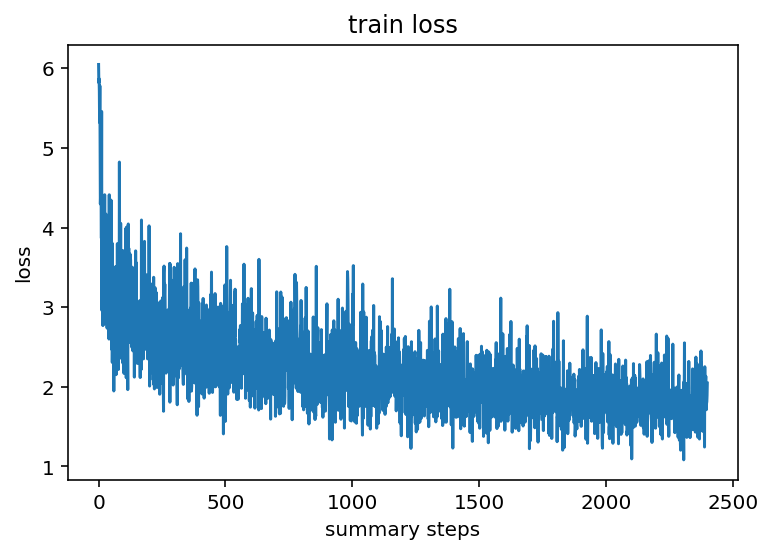

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('summary steps')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

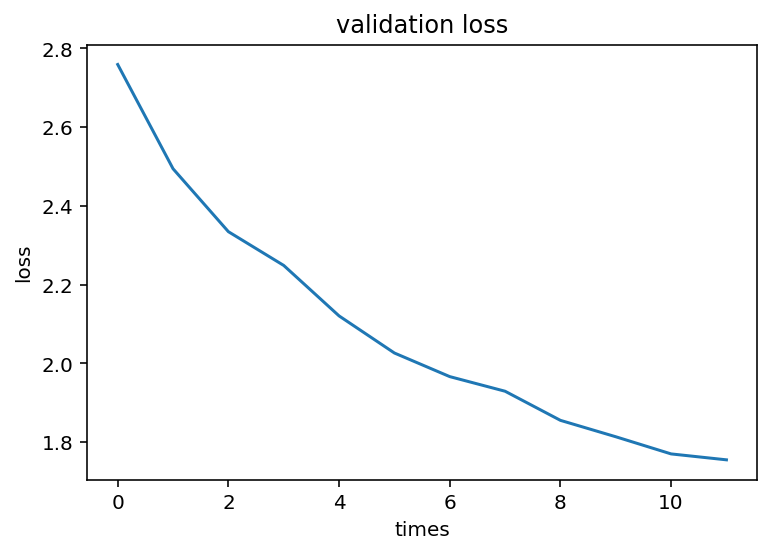

In [28]:
plt.figure()
plt.plot(val_losses)
plt.xlabel('times')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

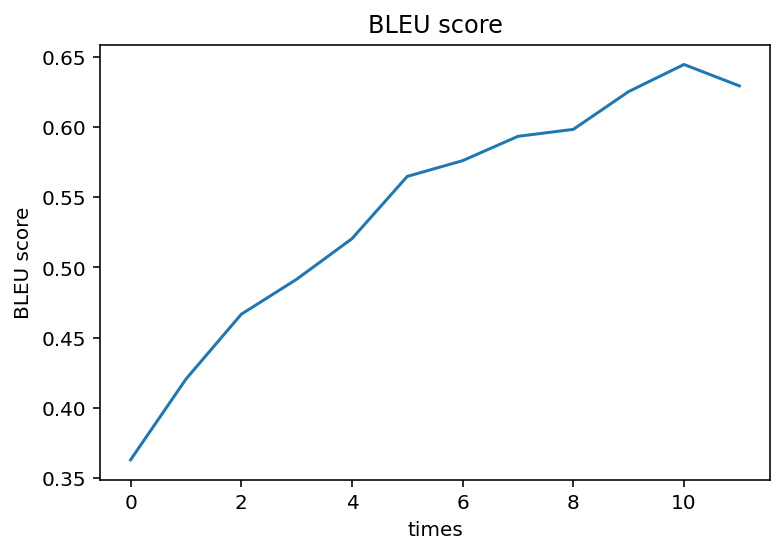

In [32]:
plt.figure()
plt.plot(bleu_scores)
plt.xlabel('times')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()

In [20]:
config.load_model = True

test_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
test_loader = data.DataLoader(test_dataset, batch_size=1)
model, optimizer = build_model(config, test_dataset.vocab_size)

data_folder_name_rhythm_dict = data_folder_name+'/rhythm_dict'
vocab_int2word,vocab_word2int = load_dictionary_as_json(data_folder_name_rhythm_dict)

embedding_list = []
for index in vocab_int2word:
    word_idx_tensor = torch.LongTensor([int(index)]).to(device)
    embedding = model.encoder.embedding(word_idx_tensor)
    embedding_list.append(embedding)

rhythm_pattern_list_all.data dataset size: 1019
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(455, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(455, 256)
    (attention): Attention()
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2vocab2): Linear(in_features=2048, out_features=4096, bias=True)
    (embedding2vocab3): Linear(in_features=4096, out_features=455, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention/model_12000


In [22]:
print(len(embedding_list))

455


In [25]:
temp_embed_tensor = preds = torch.cat(embedding_list, 0)
print(temp_embed_tensor.shape)
embedding_list = temp_embed_tensor.tolist()

torch.Size([455, 256])


In [23]:
import matplotlib as plt
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.font_manager import *  
import matplotlib.pyplot as plt 

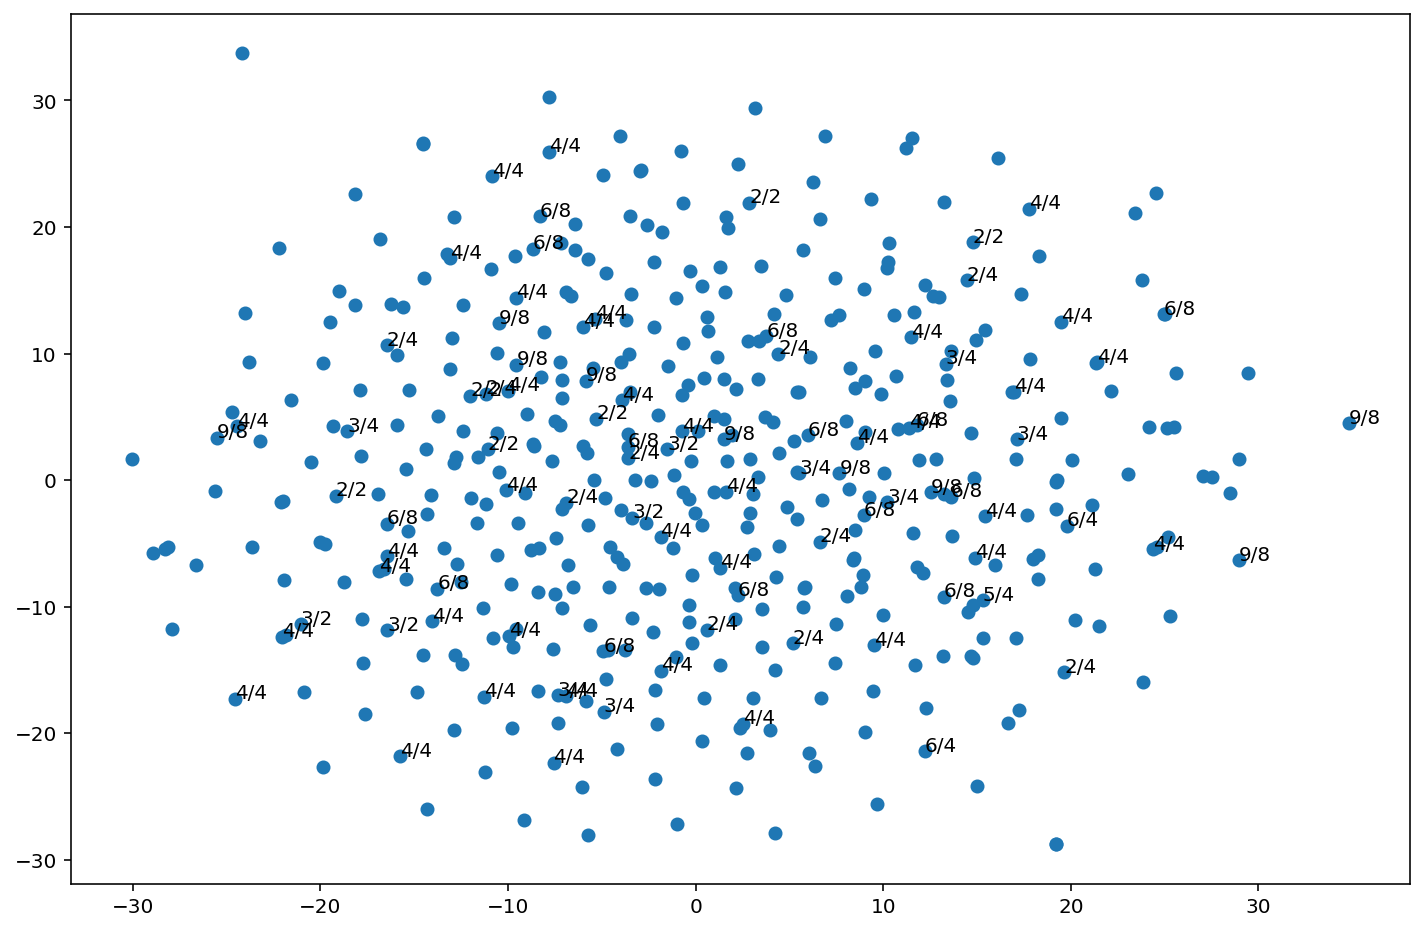

In [32]:
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(np.array(embedding_list))
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1])
for i in range(len(X_tsne)):
    if i%5==0:
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        string_tmp = vocab_int2word[str(i)]
        meter_index = string_tmp.find('|')
        if meter_index>=0:
            suffix = string_tmp[meter_index+1:]
            ax.text(x , y , suffix ,size = 10)

plt.show()

rhythm_pattern_list_all.data dataset size: 1019
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(455, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(455, 256)
    (attention): Attention()
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2vocab2): Linear(in_features=2048, out_features=4096, bias=True)
    (embedding2vocab3): Linear(in_features=4096, out_features=455, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-05
    weight_decay: 0
)
Load model from /content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_attention/model_12000
torch.Size([455, 256])


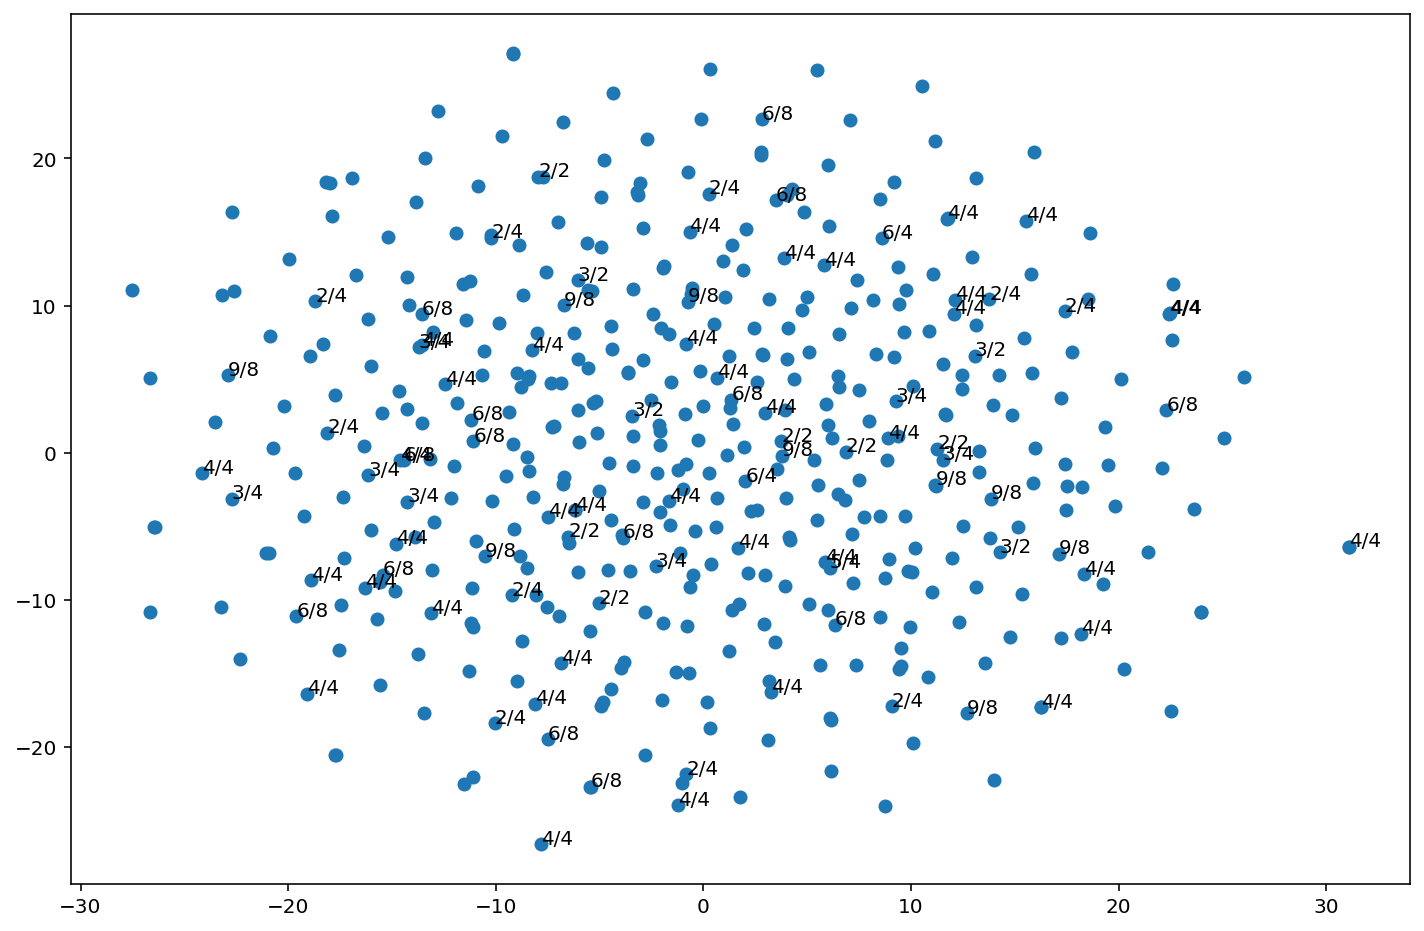

In [33]:
config.load_model = True

test_dataset = RhythmDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
test_loader = data.DataLoader(test_dataset, batch_size=1)
model, optimizer = build_model(config, test_dataset.vocab_size)

data_folder_name_rhythm_dict = data_folder_name+'/rhythm_dict'
vocab_int2word,vocab_word2int = load_dictionary_as_json(data_folder_name_rhythm_dict)

embedding_list = []
for index in vocab_int2word:
    word_idx_tensor = torch.LongTensor([int(index)]).to(device)
    embedding = model.decoder.embedding(word_idx_tensor)
    embedding_list.append(embedding)

temp_embed_tensor = preds = torch.cat(embedding_list, 0)
print(temp_embed_tensor.shape)
embedding_list = temp_embed_tensor.tolist()

X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(np.array(embedding_list))
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1])
for i in range(len(X_tsne)):
    if i%5==0:
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        string_tmp = vocab_int2word[str(i)]
        meter_index = string_tmp.find('|')
        if meter_index>=0:
            suffix = string_tmp[meter_index+1:]
            ax.text(x , y , suffix ,size = 10)

plt.show()